In [40]:
#hide
from fastbook import *

In the previous chapter, we learnt about CNNs and how to improve their training process.In this lesson
we would be discussing about ResNet(residual network) architecture which is built on top of the CNNs
and is also used for computer vision problems.Its a very new model and was introduced in 2015 only 
and now it is one of the widely used model for computer vision today.

We would discuss about resent model architecture and also this time we won't be using MNISt dataset
instead we would be using a bit complex dataset.

# ResNets

In the previous chapter we built a CNN model for whole MNIST dataset which was giving an accuracy of 
99% already.It would be tought to improvise upon the same now since the accuracy is already very high.
So we would be using a more challenging Image Classification problem using Imagenette.It is a small
subset of 10 classified classes from Imagenet dataset.

We will be using small sized images to make training faster so the images are already resized to 160px
and random cropping will be done to 128px.

## Going Back to Imagenette

First let us get the data and the path to it using the untar_data.We define a function get_data 
through which we pass the url to the dataset,the size after presizing(presize) and the size after 
random crop(resize).In the function we set the path to the data using untar_data which downloads and
extracts the data in the path.Next the function returns the dataloaders object for the dataset formed
using the DataBlock API using the dataloaders method.

While forming DataBlock we pass the Input(Image Block) and Output(Category Block),get_image_files to
get the images,splitter for training and validation split,get_y using the parent folder name,the item
transformations invole resizing the image till the passed presize(160px) and then batch transformation
include the default aug_transforms which do a Random crop till the passed resize=128 px and cropping 
by a scale of 0.5.We also do batch normalization in the batch transforms using the Normalize function.
using the imagenet statistics.Let's define the function for getting dataloaders then..

Before defining the function to get dataloaders we explore the dataset a little and download the url
and using ls() method see the contents of the directory.

In [41]:
#Downloads and extracts the dataset
state=untar_data(URLs.IMAGENETTE_160)

In [42]:
#sets the path for the dataset
Path.BASE_PATH=state

In [43]:
#ls method to see the folders inside the dataset
state.ls()

(#2) [Path('train'),Path('val')]

In [44]:
(state/'train').ls()

(#10) [Path('train/n01440764'),Path('train/n02102040'),Path('train/n02979186'),Path('train/n03000684'),Path('train/n03028079'),Path('train/n03394916'),Path('train/n03417042'),Path('train/n03425413'),Path('train/n03445777'),Path('train/n03888257')]

In [45]:
#Function for getting the dataloaders
def get_data(url, presize, resize):#(url(for data),size before batching data,size for batch transform)
    path = untar_data(url)#untar_data for downloading and extracting the data
    return DataBlock(#Image Block-Input,CategoryBlock-output
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,#get_image_files
        splitter=GrandparentSplitter(valid_name='val'),#training validation split using train,val 
        #folder,labels using the parent folder label
        get_y=parent_label, item_tfms=Resize(presize),#transformation before batching-Sizing to 160px
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),#Batch transformations-Random crop to
                    #128px and normalize the data using the dataset statistics
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128,num_workers=0)#getting dataloaders.pass the path,batch size.

Next we call the get_data function and pass the URL for Imagenette dataset,the size for presizing and 
the size for random resize crop.It returns the dataloadrs object which is stored in a different 
variable dls.

In [46]:
#get dataloaders object using the get_data function
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

We can now see some of the images before training the model using the show_batch function of the 
dataloaders.

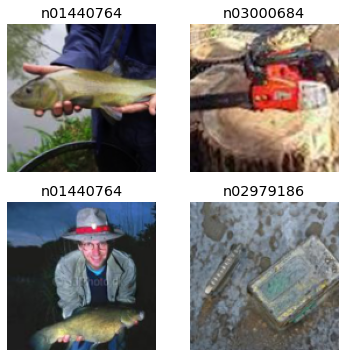

In [47]:
#Displaying some initial batch images
dls.show_batch(max_n=4)

In MNIST dataset in last chapter,we used 28X28 px pictures.For training model in this chapter,we would
be training the model on 128X128 px pictures which we got after applying batch transformations on the
mini-batch in the data using the DataBlock API.Since we are doing classification so at the end of
network we expect to get an activation vector with elements equal to the total number of classes in 
our problem as each element will have the probability for prediction for each class.

We reduced the number of activations at the end of network using the stride 2 convolution in the last
chapter such that the last layer has only one grid size.Then we use Flatten the unit axes from the 
output to get one activation vector for each image.We can use the same method for the Imagenette data
also but we would need many stride-2 convolution layers and the model would not work on images of
other sizes.

One solution to this is that the final layer can be flattened such that it can take a grid size of 
more than 1 also.We would convert the matrix into the 1d vector like we had done previously.This 
approach was followed in CNNs till 2013 but it acquired lot of memory space while flattening the layer
so final layers would then have many inputs and thus many weight matrices.

This was solved using the concept of fully convolutional networks.Fully convolutional networks(FCNs)
are composed of convolutional layers but without any connecting layer in between the convolutional 
layers.It simply takes the mean of the activations across the convolutional grid.The following 
function "avg_pool" takes the mean of the activations across x and y axes at the end of all the 
convolutional layers.

In [48]:
def avg_pool(x): return x.mean((2,3))

Here also we will be forming the model in the same way by passing a function for convolution 4 to 5 
times in the model to get convolutional layers.This time the difference is that in the function for 
convolution we won't have an extra layer for ReLU activation as instead of Conv2d we will be using 
ConvLayer which is a fully convolutional layer.This will also be a stride 2 convolutional layer.
Thus we define a function "__block__" by passing number of input(ni) and output features(nf) and it 
returns the ConvLayer with stride=2.

We also define a function "__get_model__" to get the full network with all the layers.This network
forms a number of convolutional layers and at the end has an average pooling layer which takes the 
mean of activations across the whole grid.Instead of the "__avg_pool__" function which we defined 
earlier we use PyTorch's versatile module "__nn.AdaptiveAvgPool2d__" which provides average of grid of
activations in whatever size we pass,generally that is 1.After the average pooling layer,we have the 
flatten layer to remove the unit axes and at last a linear layer

In [49]:
#function for each fully convolutional layer
def block(ni, nf): 
    return ConvLayer(ni, nf, stride=2)#PyTorch's ConvLayer
#function for fully convolutional network
def get_model():
    return nn.Sequential(
        block(3, 16),    #Calling block 5 times to get 5 convolutional layers
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),#Average pooling layer which takes mean of the activations across
        #convolutional grid
        Flatten(),#Flattening to remove the unit axes
        nn.Linear(256, dls.c))

Now while forming the fully convolutional network we have 5 convolutional layers from which we get
4 dimensional activations of size "__bs X ch X w X h__" where bs is batch size(no of images),ch is 
channels and w and h are width and height respectively.To eliminate the last two axes ,we take mean 
over the last 2 axes and obtain unit axes there which are flattened using the Flatten() layer.

Next we create a learner so that we can train our model further.We define a function "__get_learner__"
which returns the Learner.Through the function we pass the model architecture.The function returns 
the Learner through which we pass the dataloaders object,the model,loss function,metrics.
Next we call the get_learner function and in the argument we call the get_model function which returns
the model architecture which in turn is passed in get_learner function which returns the learner.
We store the learner in a different variable.

In [50]:
#get_learner function to get learner
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()#dataloaders,model,loss function,metrics is passed through the learner

learn = get_learner(get_model())#returns the learner using the model returned by get_model.

After getting the learner before training the model we use fastai's learning rate finder to get the 
optimal learning rate.

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.00363078061491251)

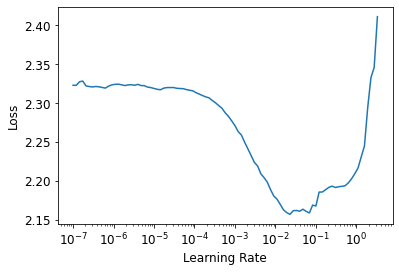

In [51]:
#Learning rate finder
learn.lr_find()

From the plot learning rate = 3 X 10^-3 seems a good learning rate as at this point the loss is 
continuously decreasing and far before the point of sharp increase in the loss.So next we train the 
model with this learning rate for 5 epochs.

In [52]:
#training the model for 5 epochs using 1 cycle training method
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.875343,1.928066,0.371210,00:28
1,1.519637,1.424775,0.533248,00:28
2,1.299104,1.214928,0.616815,00:29
3,1.137969,1.120316,0.649682,00:28
4,1.055927,1.069376,0.661911,00:29


So after training the model for 5 epochs we have an accuracy of around 65% for a model which has 10
categories for classification.This seems good for a baseline model.It can be improved using a more 
deeper model but just adding new layers would not improve the model.So to improve the model accuracy
without actually adding more layers we will be using the concept of skip connections.ResNet models 
use skip connections.Let's explore that and some more aspects of resnets further:-

## Building a Modern CNN: ResNet

We built a classification model on Imagenette using the Fully conventional network and achieved an 
accuracy of 65%.Now we will be discussing about the model we have been using in this course for all 
the computer vision tasks known as "ResNets".We will discuss about the main concept behind the ResNet
,how it is different from CNNs and how it improves accuracy on the ImageNette model.

### Skip Connections

Resnet was introduced in 2015.After some experiments it was observed that even after using batchnorm
in the model,the model with less no of layers was performing better than the model with more number of
layers.This was very strange as with Imagenette the images are more complex so deeper model should 
perform better.This was observed in both training and validation sets so it was mostly a training 
error.The training error and test error for different layered models can be summarized in below graphs
:-
<img alt="Training of networks of different depth" width="700" caption="Training of networks of different depth (courtesy of Kaiming He et al.)" id="resnet_depth" src="images/att_00042.png">

As expected 56 layer model should be better than the 20 layer model but here it performs worse than 
the 20 layer model.One of the reasons which the researchers stated that because if we start with a 20
layered model trained already and then add more 36 layers which are just linear layers with a weight 
of 1 and bias 0 then they would obviously learn nothing.So deep neural networks cannot perform better
than small network if they are shallow networks.


There are some other ways also through which we can create the extra 36 layers.if in every call for 
convolutional layer we return "__x+conv(x)__" instead of just conv(x) where conv is the function from
previous chapter which has an additional layer ReLU apart from convolutional layer and a batchnorm 
layer too.And batchnorm also returns a "__gammaXy+beta__".If gamma is initialized as zero then the 
conv(x) will be zero for rest of the 36 layers and the model will return x as conv(x)=0.

These 36 layers may seem useless but since they are identical to each other hence it is called 
"identitiy mapping".Also these layers have parameters so they can be trained.So we train our model 
such that initially we have a pretrained 20 layer model then we add 36 layers which are of no use as
such and then we fine tune the whole 56 layer model for some epochs.These layers learn parameters 
later in the training process.

ResNet performs this in a little different way.While training it leaves every second convolution and
thus the method is known as "skipped connections".It can be summarized by the below figure as follows:
<img alt="A simple ResNet block" width="331" caption="A simple ResNet block (courtesy of Kaiming He et al.)" id="resnet_block" src="images/att_00043.png">

The figure above shows that the network skips over every second convolution and provides a direct path
indeed.

In ResNet we do not start with a small number of layers and then add layers and fine-tune them.Instead
Resnet block function or class is created like we had created block in CNN and trained with SGD.And
skip connections is used to make training fast and efficient.

In mathematical terms it can be explained as that if the output from a layer is x if we use a ResNet
block it will return y=x+block(x).And the next block would predict the difference between y and x.So
ResNet blocks do not predict the output y instead they minimize the difference between y and x.ResNet
model is thus good at learning the differences and this is from where it also gets its name as it
predicts residuals so the name is Residual Network.

Let's see the definition of a simple ResNetBlock.What we discussed previously is happening here that
it returns x+conv(x) instead of x and also it skips one convolutional layer and the NormType.BatchZero
makes gamma zero in the last BatchNorm layer.Also in forward it returns x+conv(x).

In [53]:
#Definition of a ResNet Block
class ResBlock(Module):
    def __init__(self, ni, nf):#pass input channels and output features
        self.convs = nn.Sequential(
            ConvLayer(ni,nf),#fully convolutional layer
            ConvLayer(nf,nf, norm_type=NormType.BatchZero))#second convolutional layer with the batch
        #normalization.The Normtype.BatchZero makes gamma zero while returning the output
        
    def forward(self, x): return x + self.convs(x)#returns the x+convs(x)

The above ResNet block cannot handle the strides more than 1 and it requires ni to be equal to nf.
We cannot pass a layer with stride 2 convolution because the ouput would have the half the size of
input.So x cannot be added to convs(x) as they would have different dimensions.Also if ni is not equal
to nf they cannot be added back.

To avoid these problems,x size can be modified such that it matches with the output and then applying
an average pooling layer with a stride 2 convolution which halfs the grid size.

We also do a simple convolution there by taking a kernel size 1 X 1.This convolution doesn't combine
pixels instead takes a dot product for each input pixel.This is used a lot in modern CNNs.Let's see 
how it can be executed in code...


We define a function "__conv_block__" for convolutional layer specially through which we pass number 
of input channels,output features and stride.It returns the network of two convolutional layers with 
a stride and batch normalization too.Next we define the class "__ResBlock__" object through which we 
pass ni,nf and stride.We use conv_block to get the Convolutions and pool for Average pooling of the 
activations with a stride of 2.

In [54]:
#Function for convolutions layer
def _conv_block(ni,nf,stride):#number of inputs,no of output features and the stride
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),#input,output and stride
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))#input,output,no ReLU activation
        #,Batchnormalize

In [55]:
#ResNet Block class  
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)#Convolutional layer
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)#Identical convolution
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)#Pooling layer
        #Skipped connection

    def forward(self, x):#Activation after skipped connection
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In "__init__" function we define the object for convolution layer.Next we define Identity Mapping if 
ni is not equal to nf else we use noop function which simply returns the same input as it means no
operation.In the same way we define pooling layer next which returns the same input if stride=1 else
it performs the pooling which is what is meant by skipped connection.

ReLU activation is removed fro final convolution in "idconv" and "convs" and it is done in forward
function while we return the output which convs(x)+idconv(pool(x)) and ReLU activation of this is 
returned.

So ResNet acts like a layer and the activation is after layer.Next in the block function we return the
Resnet Block and pass ni,nf and a stride of 2 through it.Next we call get_model which returns the 
model architecture and then we pass it through the get_learner function to get the learner.

In [56]:
#Block for each layer in the final model
def block(ni,nf): 
    return ResBlock(ni, nf, stride=2)#Returns output of the resnet model
learn = get_learner(get_model())#get the learner by passing the model architecture

Now as we have got learner let's train the model using fit_one_cycle method for 5 epochs and the 
learning rate 3 X 10^-3.

In [57]:
#Training the model 
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.990232,1.873274,0.343694,00:57
1,1.688511,1.503445,0.511592,00:58
2,1.381662,1.264957,0.586497,00:57
3,1.180499,1.138770,0.640510,00:57
4,1.044909,1.056210,0.665478,00:57


The accuracy has not improved much from the baseline model.We can still train more deeper models to 
improve the accuracy.To create a model twice as deeper as the previous one in the block function we 
form a network of two ResBlock one after other in a row.

In [58]:
#Modified convolutional block which returns a network of two ResBlock blocks.
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

Next we get the learner by passing the model architecture returned by the get_model function.And then
we train the model for the same number of epochs and learning rate.

In [59]:
#Get the learner
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)#Training the model

epoch,train_loss,valid_loss,accuracy,time
0,1.946178,1.801965,0.375541,01:44
1,1.609352,1.499476,0.522293,01:43
2,1.322493,1.200108,0.610955,01:43
3,1.097579,0.998446,0.680764,01:43
4,0.944938,0.942256,0.690955,01:43


The accuracy has improved but not that much still.This ResNet model won the ImageNet competition in 
2015.The idea behind these models did not come from mathematics infact it was the result of pure 
experimental observations,observations about what information the layer is learning and which kind of 
network gives which kind of results.Researchers have said that deep learning is not only mathematics 
but it is an experimental field also as it requires several experiments to understand about the models
and data.

Let's learn about some more tricks which can make the model better:-

### A State-of-the-Art ResNet

Researchers have studied different variants of ResNet architecture which do not require extra memory 
or parameters.They have improved the accuracy on Imagenet dataset to 94.6%  by using ResNet-50 with 
some Mixup which was 92.2% without mixup.These results were better than what was achieved using more
deep models which were twice as deep as ResNet-50.
Mixup is considered one of the regularization technique which was introduced recently in 2018.Mixup 
trains a neural network on combinations of pairs of images and their labels and in this way avoids 
overfitting by regularizing the network.Various experiments of mixup on different datasets such as 
Imagenet,CIFAR-10,MNIST etc have improved the generalization of models.Two images which may or may not
belong to same class are combined using the following formula:-

new_Image=t X (Image1) + (t-1) X (Image2)

Here t is a float number between 0 and 1.In the same way the new target for the image is also combined
using target1 and target2. 

new_target=t X (target1) + (t-1) X (target2)

If the targets are one hot encoded then the above expression is used else a custom loss function is 
used.We would learn more about them in detailed later.

The model we would be using next is a little tweaked one.Instead of resent blocks we use some 
plain convolutional layers with a pooling layer.This part of the architecture is called stem of the 
network therefore we also name the function as resnet_stem.

In deep neural networks most of the computation occurs in early layers and therefore the initial 
layers should be simple and fast and therefore in this model we use simple convolutional layers.

In [60]:
#stem part of the network
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1) #Convolutional layers
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]#Pooling layer

In [61]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

Previously also we have mentioned that most of the computation occurs in early layers in deep neural
networks.This can be explained using a convolution on a 128 X 128 pixel image.In stride 1 convolution
kernel is applied to each pixel which is a complex computation and time consuming also.As the stride 
is 2 for later layers the grid size becomes small in later layers so calculations are also less in 
later layers.

Resnet Block is more time consuming than the convolutional block as it has three convolutional layers
and one pooling layer therefore its better to use plain convolutional block.

Let's see the implementation of modern ResNet model.There are four blocks of ResNet with 64,128,256 
and 512 filters.For first block the stride is 1 for rest of the blocks it is 2.As it is after the
maxpooling layer.

In the below model definition in the "__init__" we pass the number of outputs and the number of layers
.Next we define the resnet_stem block.After that we define the block sizes.After that we iterate 
through the block sizes and expand it exponentially using the previous layer size.Next we define the
blocks which create the layers using the make_layer function while iterating through the number of 
layers.Last line summarizes the whole layer which consists of the stem convolution,then the four 
ResNet Blocks followed by the Average pooling layer the flattening layer and the last Linear layer
which has the input equal to last block size and the output is equal to the number of output passed 
through the main class.

In [62]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)#resnet stem block
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): 
            self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

The "__make_layer__" function creates the series of blocks equal to n_layers.After the blocks are
defined,the model is sequential hence it is defined in nn.Sequential.

Previously we have used different variants of ResNet such as ResNet 18,34 and 50.These are just 
varying number of blocks in each model.The above is the definition of ResNet-18.

Next we create an object of the ResNet class by passing the number of classes in dataloaders and a 
list of number of layers in each block.

In [63]:
#Create object for the model
rn = ResNet(dls.c, [2,2,2,2])#(number of classes,number of layers in each block)

Next we pass the model object through the get_learner function to get the learner and then train the 
model for 5 epochs and a learning rate of 3 X 10^-3.

In [64]:
#Get learner
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)#Training the model for 5 epochs 

epoch,train_loss,valid_loss,accuracy,time
0,1.749013,1.958248,0.382166,01:55
1,1.350609,1.398591,0.569427,01:55
2,1.089715,1.356734,0.594650,01:55
3,0.891844,0.812580,0.744713,01:55
4,0.747642,0.768748,0.753631,01:55


Though the architecture of the model is more complex here ,the training is more faster because of the
stem convolutional layers.The model also improves the accuracy by a good amount using the stem layers
and then the ResNet blocks.

Next we make a more deeper model without consuming a lot of memory by adding the Bottleneck layer.It
is used with resnet architectures of more than a depth of 50.

### Bottleneck Layers

In the previous model for the stem layers we were stacking two convolutional layers with a kernel size
of 3 X 3.In a bottleneck layer we use three convolutional layers two with 1 X 1 kernel size and one of
3 X 3 kernel size.The below figure explains the bottleneck layer:-
    
<img alt="Comparison of regular and bottleneck ResNet blocks" width="550" caption="Comparison of regular and bottleneck ResNet blocks (courtesy of Kaiming He et al.)" id="resnet_compare" src="images/att_00045.png">

Though the number of layers are more in bottleneck but since 1 X 1 convolution is fast so it is 
executed faster than the ResNet block.The number of filters which can be used are also more in 
bottleneck layer.So we can actually use more number of filters in bottleneck layer without compromisin
-g with the time required for execution of the model.
Thus we replace the ResBlock with the conv_block.We create ResNet-50 model and start with  channels 
down scaled by 4 so that we have 4 times more channels in output.

In [65]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

This is a deep network which gives results after 5 epochs only so we start training our model for 
20 epochs to improve the accuracy further.Also this time bigger images are used as the training data
which are resized to 320 px before loading it in dataloaders and then cropped to 224 px again.

So to get dataloaders for new size Images we pass the url and presize,resize values through the
get_data function and call it.Though the images are big still it works as fully convolutional models 
are able to fine tune the models with different image sizes.

In [66]:
#get dataloaders by passing the url,presize and resize values to the get_data function
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

Next we create an object for the ResNet architecture pass it through the get_learner function to get
the learner and then train it for 20 epochs.

In [67]:
#object for Resnet(dataloaders classes,the list of numer of layers in each block,the expansion 
rn = ResNet(dls.c, [3,4,6,3], 4)

In [68]:
learn = get_learner(rn)#the learner
learn.fit_one_cycle(20, 3e-3)#Training for 20 epochs

RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 6.00 GiB total capacity; 3.74 GiB already allocated; 192.91 MiB free; 3.96 GiB reserved in total by PyTorch)

The accuracy has improved a lot in this model because of adding bottleneck layers and creating a deep
model without increasing the training time also.

The bottleneck layer is used only in deeper ResNet models such as 50,101 and 152 layered models.Lower
ones such as ResNet 18 and 34 use non bottleneck layer which we used in previous section.Bottleneck
layer may not give better results on every data but certainly gives with some models.Thus exploring 
and experimenting is always good as it is from there only we get ideas such as the ResNet which we 
implemented in this lesson.

## Conclusion

In the previous chapters we use resnet models to build Image Classifiers.We saw in detailed about how
resnet architecture is executed using the skip connections.There is continuous research going on for 
developing better architectures.ResNet is still the most preferred model for transfer learning now 
also.In the next chapter we would look into more details about how the other models which we used also
had ResNet architecture...

## Questionnaire

1. How did we get to a single vector of activations in the CNNs used for MNIST in previous chapters? Why isn't that suitable for Imagenette?
1. What do we do for Imagenette instead?
1. What is "adaptive pooling"?
1. What is "average pooling"?
1. Why do we need `Flatten` after an adaptive average pooling layer?
1. What is a "skip connection"?
1. Why do skip connections allow us to train deeper models?
1. What does <<resnet_depth>> show? How did that lead to the idea of skip connections?
1. What is "identity mapping"?
1. What is the basic equation for a ResNet block (ignoring batchnorm and ReLU layers)?
1. What do ResNets have to do with residuals?
1. How do we deal with the skip connection when there is a stride-2 convolution? How about when the number of filters changes?
1. How can we express a 1×1 convolution in terms of a vector dot product?
1. Create a `1x1 convolution` with `F.conv2d` or `nn.Conv2d` and apply it to an image. What happens to the `shape` of the image?
1. What does the `noop` function return?
1. Explain what is shown in <<resnet_surface>>.
1. When is top-5 accuracy a better metric than top-1 accuracy?
1. What is the "stem" of a CNN?
1. Why do we use plain convolutions in the CNN stem, instead of ResNet blocks?
1. How does a bottleneck block differ from a plain ResNet block?
1. Why is a bottleneck block faster?
1. How do fully convolutional nets (and nets with adaptive pooling in general) allow for progressive resizing?

### Further Research

1. Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you'll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?
1. In <<chapter_foundations>> we introduce *Einstein summation notation*. Skip ahead to see how this works, and then write an implementation of the 1×1 convolution operation using `torch.einsum`. Compare it to the same operation using `torch.conv2d`.
1. Write a "top-5 accuracy" function using plain PyTorch or plain Python.
1. Train a model on Imagenette for more epochs, with and without label smoothing. Take a look at the Imagenette leaderboards and see how close you can get to the best results shown. Read the linked pages describing the leading approaches.

# Answers

Ans-1 In the previous chapter the CNN we built for MNIST dataset we started with input images of size
28 X 28 px.We used stride 2 convolutions such that the final layer has a grid size of 1 and then the 
unit axes obtained after the last convolutional layer were flattened using a Flatten layer so at last
we obtained a single activation vector for each image.This cannot be used with Imagenette as if image
size is big then many stride 2 convolution layers would be required to bring the grid size to 1 X 1.
The training process would be very slow.

Ans-2 For Imagenette fully convolutional networks can be used which take average of activations over 
the convolutional grid.The ReLu activation after every convolutional layer is eliminated here and a 
fastai's Convs Layer is used and after all convolutional layers there is the pooling layer which takes
average of activations and reduces it into any grid size we require.Next is the flattening layer and 
the linear layer.

Ans-3 Adaptive pooling is used for dimensionality reduction.Like average pooling it doesn't require 
us to pass the kernel size,padding or stride through it.We usually pass only the output size we want 
and the layers infers it directly according to the input size and shape.

Ans-4 Average pooling is also used for dimensionality reduction by taking average of the activations 
across the grid.In average pooling but we need to pass the kernel size and stride size for pooling.

Ans-5 After the adaptive average pooling still the activations are not in the form of vector,average
pooling doesn't remove the axis instead makes it unit.So flatten is required to remove the unit axes.

Ans-6 Sometimes the deeper networks perform bad than the shallow networks also as the extra deeper 
layers basically do nothing in the network.First the network which returns conv(x) is made to return
x+conv(x).And in ResNet,the model skips over every second convolution and thus the output becomes 
x+conv2(conv1(x)).The model is trained in usual way using SGD and makes the training easier using 
skip connections.

Ans-7 skip connections help in training deeper networks in a faster way as it skips every second 
convolutional layer.In deeper layers the vanishing gradients is a problem,ResNet in a way preserves 
the gradient by stacking the skipped residual blocks together.Preserving gradient allows us to train
more deeper models.

Ans-9 Identity mapping is returning the input function without changing anything.It allows adding
extra layers to the model which are untrained.Initially they may not do anything but since they 
contain parameters which are learnable so they can be fine-tuned to learn the useful parameters.

Ans-10 x+block(x)

Ans-11 ResNet instead of predicting the output y predicts the difference between y and x.The ResNet
blocks minimize the difference between x and the predicted y.A ResNet since predicts and learns the 
difference that is why it is called residual network as its predicting residuals.

Ans-12 When we use stride 2 convolution we need to do something to make the dimension of x equal to 
conv(x).The grid size is reduced by using an average pooling layer which takes 2 X 2 windows from the
input and pools its average.When the number of filters change,the skip connections is done by making 
the convolution as simple as possible that is using a 1 X 1 kernel which does a dot product over the 
input pixel.

Ans-13 A 1 X 1 convolution means doing dot product over the channels of every input pixel.There is no
pooling or combining.

Ans-14 The image size will remain same.

Ans-15 noop function stands for no operation.It returns the input unchanged.

Ans-17 top-5 accuracy is a good metric to use when the image contains many objects or contain objects
are similar so they can be mislabelled easily.In such situations looking at top-1 accuracy is of no 
use.

Ans-18 The first few layers of a neural network are called the stem of the network.

Ans-19 In deep neural network most of the computations occur in the initial layers therefore the early
layers should be fast and simple.ResNet block require more computation than the convolutional blocks
and therefore it is better to use convolutional blocks as stem in ResNet as it makes the training fast
and simple.

Ans-20 A plain ResNet block consists of 2 convolutional layers with a kernel size of 3 X 3,bottleneck
layer consists of 3 convolutional layers with a kernel size of 1 X 1 for two layers and 3 X 3 for one.

Ans-21 Bottleneck layer consists of 1 X 1 convolutions which are much faster than the 3 X 3 
convolutions in normal block.Even if there are 3 layers in it but still it is executed faster than the 
normal block.

Ans-22 Fully convolutional networks allow training of the bigger images also.We can fine-tune the models trained for images with different sizes.